<a href="https://colab.research.google.com/github/Hilly12/pcl_detection/blob/main/NLP_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Coursework

## Setup

In [21]:
from IPython.display import clear_output

!pip install pytorch_lightning
!pip install simpletransformers
!pip install tensorboardx
!pip install transformers

import os
import numpy as np
import pandas as pd
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
from collections import Counter
from ast import literal_eval
from sklearn.metrics import f1_score

ON_COLAB = True

clear_output()

!nvidia-smi

Fri Mar  4 00:14:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    33W / 250W |  11881MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

!gdown --folder https://drive.google.com/drive/folders/1XBeRuDSgLziIdTllN4kc3ER2jBgbWI_q

if ON_COLAB:
    !cp --recursive NLP/* .
    !rm -rf NLP

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py
Retrieving folder list
Processing file 16krDXIGeUbpNTIjLKVpBWVHHWIfkwLan dev_semeval_parids-labels.csv
Processing file 1KLEzJBaN7JcpSUrqJwMIV38sU0E3v2RV dontpatronizeme_categories.tsv
Processing file 1X5vMS2MjqT5pDPms87LZqoPmgeX-Hwg2 dontpatronizeme_pcl.tsv
Processing file 1U2cNPyLph0POZTPHcP55iEAIIvCVynMF train_semeval_parids-labels.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=16krDXIGeUbpNTIjLKVpBWVHHWIfkwLan
To: /content/NLP/dev_semeval_parids-labels.csv
100% 61.2k/61.2k [00:00<00:00, 74.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KLEzJBaN7JcpSUrqJwMIV38sU0E3v2RV
To: /content/NLP/dontpatronizeme_categories.tsv
100% 1.34M/1.34M [00:00<00:00, 164MB/s]
Downloading...
From: https://drive.google.com/uc?id=1X5vMS2MjqT5pDPms87LZqoPmgeX-Hwg2
To: /con

In [23]:
from dont_patronize_me import DontPatronizeMe
 
dpm = DontPatronizeMe('.', '.')
dpm.load_task1()

## Data Loading

In [24]:
train_ids = pd.read_csv('train_semeval_parids-labels.csv')
test_ids = pd.read_csv('dev_semeval_parids-labels.csv')
train_ids.par_id = train_ids.par_id.astype(str)
test_ids.par_id = test_ids.par_id.astype(str)

def ids_to_df(ids):
    rows = [] # will contain par_id, label and text
    for idx in range(len(ids)):
        parid = ids.par_id[idx]

        # select row from original dataset to retrieve `text` and binary label
        row = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid]
        text = row.text.values[0]
        label = row.label.values[0]
        keyword = row.keyword.values[0]
        country = row.country.values[0]
        orig_label = int(row.orig_label.values[0])

        rows.append({
            'par_id': parid,
            'text': text,
            'label': label,
            'orig_label': orig_label,
            'kwd': keyword,
            'country': country
        })

    return pd.DataFrame(rows)

In [25]:
train_df1 = ids_to_df(train_ids)
train_df1.head()

,par_id,text,label,orig_label,kwd,country
0,4341,"The scheme saw an estimated 150,000 children f...",1,4,poor-families,gb
1,4136,Durban 's homeless communities reconciliation ...,1,2,homeless,za
2,10352,The next immediate problem that cropped up was...,1,4,poor-families,lk
3,8279,Far more important than the implications for t...,1,2,vulnerable,nz
4,1164,To strengthen child-sensitive social protectio...,1,4,poor-families,gh


In [26]:
test_df1 = ids_to_df(test_ids)
test_df1.head()

,par_id,text,label,orig_label,kwd,country
0,4046,We also know that they can benefit by receivin...,1,3,hopeless,us
1,1279,Pope Francis washed and kissed the feet of Mus...,1,4,refugee,ng
2,8330,Many refugees do n't want to be resettled anyw...,1,2,refugee,ng
3,4063,"""Budding chefs , like """" Fred """" , """" Winston ...",1,4,in-need,ie
4,4089,"""In a 90-degree view of his constituency , one...",1,3,homeless,pk


## Analysis

In [27]:
train_df1["kwd"].unique()

array(['poor-families', 'homeless', 'vulnerable', 'hopeless', 'in-need',
       'disabled', 'women', 'refugee', 'immigrant', 'migrant'],
      dtype=object)

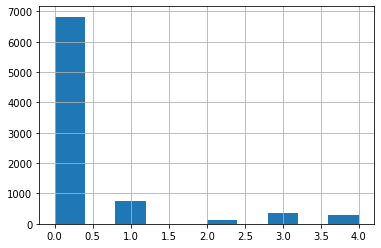

In [28]:
train_df1["orig_label"].hist()

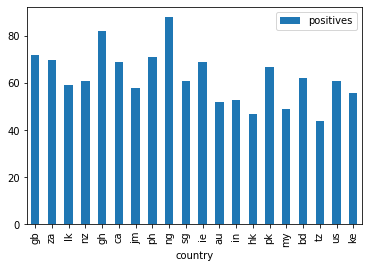

In [29]:
dfs = {}
for col in ["kwd", "country"]:
    positives = []
    for arg in train_df1[col].unique():
        group = train_df1[train_df1[col] == arg]["orig_label"]
        tp = np.sum((group == 1) | (group == 2) | (group == 3))
        positives.append({col: arg, "positives": tp})
    
    dfs[col] = pd.DataFrame(positives)

dfs["country"].plot.bar(x="country", y="positives")

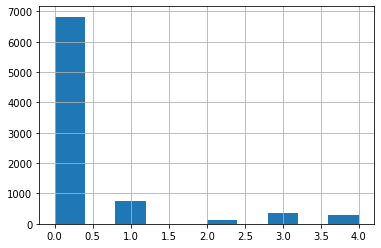

In [30]:
train_df1["orig_label"].hist()

## RoBerta Baseline

In [31]:
# downsample negative instances
pcldf = train_df1[train_df1.label == 1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf, train_df1[train_df1.label == 0][:npos*2]])
training_set1

,par_id,text,label,orig_label,kwd,country
0,4341,"The scheme saw an estimated 150,000 children f...",1,4,poor-families,gb
1,4136,Durban 's homeless communities reconciliation ...,1,2,homeless,za
2,10352,The next immediate problem that cropped up was...,1,4,poor-families,lk
3,8279,Far more important than the implications for t...,1,2,vulnerable,nz
4,1164,To strengthen child-sensitive social protectio...,1,4,poor-families,gh
...,...,...,...,...,...,...
2377,1775,Last but not the least element of culpability ...,0,0,refugee,nz
2378,1776,"Then , taking the art of counter-intuitive non...",0,0,refugee,ie
2379,1777,Kagunga village was reported to lack necessary...,0,0,refugee,tz
2380,1778,"""After her parents high-profile divorce after ...",0,1,vulnerable,my


In [32]:
task1_model_args = ClassificationArgs(num_train_epochs=2, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)

task1_model = ClassificationModel("roberta", 
                                  'roberta-base',
                                  args = task1_model_args, 
                                  num_labels=2,
                                  use_cuda=torch.cuda.is_available())
# train model
task1_model.train_model(training_set1[['text', 'label']])

https://huggingface.co/roberta-base/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp79xo955k


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
creating metadata file for /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_rang

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
creating metadata file for /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
loading weights file https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
creating metadata file for /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
https://huggingface.co/roberta-base/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpxp8rsf4j


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
https://huggingface.co/roberta-base/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp2armsjk7


Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
creating metadata file for /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta

  0%|          | 0/2382 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/298 [00:00<?, ?it/s]

(596, 0.46652582131526216)

In [33]:
# Test predictions

preds_task1, _ = task1_model.predict(test_df1.text.tolist())

print(f"Test Accuracy: {np.mean(preds_task1 == test_df1['label'])}")
print(f"Test F1-Score: {f1_score(preds_task1, test_df1['label'])}")

  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

Test Accuracy: 0.8662846227316141
Test F1-Score: 0.5000000000000001


## T5


### Helpers

In [34]:
def preprocess(df, tokenizer, prefix, max_input_tokens):
    t5_df = df[["text", "label"]].copy()
    t5_df["text_label"] = t5_df["label"].map({0: "no", 1: "yes"})

    # Downsample negative samples
    pcldf = t5_df[t5_df["label"] == 1]
    npos = len(pcldf)
    training_set = pd.concat([pcldf, t5_df[t5_df["label"] == 0][:npos * 2]])

    input_seqs = (prefix + training_set["text"]).tolist() 
    output_seqs = training_set["text_label"].tolist()

    encoding = tokenizer(
        input_seqs,
        padding="longest",
        max_length=max_input_tokens,
        truncation="longest_first",
        return_tensors="pt"
    )

    target_encoding = tokenizer(
        output_seqs,
        padding="longest",
        max_length=1,
        truncation=False,
        return_tensors="pt"
    )

    n = len(input_seqs)
    perm = np.random.permutation(n)

    input_tokens = encoding.input_ids[perm]
    attention_mask = encoding.attention_mask[perm]
    output_tokens = target_encoding.input_ids[perm]
    labels = torch.Tensor(training_set["label"])[perm]

    return input_tokens, attention_mask, output_tokens, labels


def tokens_to_dataset(input_tokens, attention_mask, output_tokens):
    data = []
    for i in range(len(input_tokens)):
        data.append({
            "input_ids": input_tokens[i],
            "attention_mask": attention_mask[i],
            "labels": output_tokens[i]
        })
    
    return data

### Training

In [ ]:
from datasets import load_metric
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer

num_epochs = 5
learning_rate = 1e-4
batch_size = 32

max_input_tokens = 128
max_output_tokens = 1
prefix = "Is patronising or condescending: "

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [36]:
os.environ["WANDB_DISABLED"] = "true"

input_tokens, attention_mask, output_tokens, labels = preprocess(
    train_df1,
    tokenizer=tokenizer,
    prefix=prefix,
    max_input_tokens=max_input_tokens
)

data = tokens_to_dataset(input_tokens, attention_mask, output_tokens)

train_data = data[:int(0.9 * len(data))]
val_data = data[int(0.9 * len(data)):]

def compute_metrics(eval_pred):
  preds, labels = eval_pred.predictions, eval_pred.label_ids
  predictions = np.argmax(preds[0], axis=2)
  acc = (predictions[:, 0] == labels[:, 0]).mean()

  return { "accuracy": acc }

training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="steps",
    eval_steps=256,
    logging_steps=128,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
)
metric = load_metric("accuracy")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2143
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumu

Step,Training Loss,Validation Loss,Accuracy
256,0.338400,0.256566,0.728033
512,0.254600,0.236735,0.774059
768,0.224300,0.240887,0.778243
1024,0.210300,0.247549,0.778243
1280,0.177800,0.242487,0.782427


***** Running Evaluation *****
  Num examples = 239
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 239
  Batch size = 8
***** Running Evaluation *****
  Num examples = 239
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 239
  Batch size = 8
***** Running Evaluation *****
  Num examples = 239
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1340, training_loss=0.3403191701689763, metrics={'train_runtime': 100.849, 'train_samples_per_second': 106.248, 'train_steps_per_second': 13.287, 'total_flos': 362546850693120.0, 'train_loss': 0.3403191701689763, 'epoch': 5.0})

In [37]:
input_tokens, attention_mask, output_tokens, labels = preprocess(
    test_df1,
    tokenizer=tokenizer,
    prefix=prefix,
    max_input_tokens=max_input_tokens
)

test_data = tokens_to_dataset(input_tokens, attention_mask, output_tokens)

raw_preds, _, test_metrics = trainer.predict(test_data)

def text_to_class(text):
    return int(text.replace("</s>", "").lower() == "yes")

pred_test_label_ids = np.argmax(raw_preds[0], axis=2)
pred_classes = np.array([text_to_class(tokenizer.decode(ids)) for ids in pred_test_label_ids])

test_acc = np.mean(pred_classes == labels.numpy())
print(f"Accuracy: {test_acc * 100}%")

test_f1_score = f1_score(pred_classes, labels)
print(f"Macro-Averaged F1 Score: {test_f1_score}")

***** Running Prediction *****
  Num examples = 597
  Batch size = 8


Accuracy: 81.4070351758794%
Macro-Averaged F1 Score: 0.7008086253369272
